# Plot surface temperature differences between model and observations


Import preamble

In [28]:
import coast
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

#### Define data paths
Set model paths.

In [29]:
path = "/gws/nopw/j04/jmmp/tmp_slwa/AMM7_SSB_sample/"
model_path = path +  "amm7_1d_20040101_20040131_grid_T.nc"
jmmp_path = "/gws/nopw/j04/jmmp/"
domcfg_path = path + "amm7_SSB_mesh_mask.nc"

Set coast config paths. COAST uses configuration files to map model variables to common variable names.

In [30]:
cfg_path = "/home/users/ryapat30/NOC/COAsT/config/"
en4_json = cfg_path + "example_en4_profiles.json"
nemo_json = cfg_path + "example_nemo_grid_t.json"

Set observation path.

In [31]:
en4_path="/gws/nopw/j04/class_vol2/senemo/shared/EN4/processed/AMM15/"
fn_prof = en4_path + "AMM15_processed_200401.nc"

#### COAST data import
COAST uses gridded objects to combine grid and data information.

In [ ]:
nemo = coast.Gridded(model_path, domcfg_path, config=nemo_json)

We can interrogate this nemo Gridded object with the .dataset method. The Gridded data is served as an xarray dataset.

In [50]:
nemo.dataset

<xarray.Dataset>
Dimensions:               (z_dim: 51, axis_nbounds: 2, t_dim: 31, y_dim: 375,
                           x_dim: 297)
Coordinates:
  * time                  (t_dim) datetime64[ns] 2004-01-01T12:00:00 ... 2004...
    longitude             (y_dim, x_dim) float32 -19.89 -19.78 ... 12.89 13.0
    latitude              (y_dim, x_dim) float32 40.07 40.07 40.07 ... 65.0 65.0
    depth                 (z_dim, y_dim, x_dim) float64 0.5 0.5 ... 50.5 50.5
Dimensions without coordinates: z_dim, axis_nbounds, t_dim, y_dim, x_dim
Data variables: (12/14)
    deptht_bounds         (z_dim, axis_nbounds) float32 0.0 6.157 ... 5.924e+03
    e3t                   (t_dim, z_dim, y_dim, x_dim) float32 dask.array<chunksize=(2, 51, 375, 297), meta=np.ndarray>
    time_centered         (t_dim) datetime64[ns] dask.array<chunksize=(2,), meta=np.ndarray>
    time_centered_bounds  (t_dim, axis_nbounds) datetime64[ns] dask.array<chunksize=(2, 2), meta=np.ndarray>
    time_counter_bounds   (t_dim, axis_nbounds) datetime64[ns] dask.array<chunksize=(2, 2), meta=np.ndarray>
    salinity              (t_dim, z_dim, y_dim, x_dim) float32 dask.array<chunksize=(2, 51, 375, 297), meta=np.ndarray>
    ...                    ...
    e1                    (y_dim, x_dim) float64 9.455e+03 ... 5.221e+03
    e2                    (y_dim, x_dim) float64 7.414e+03 ... 7.414e+03
    e3_0                  (z_dim, y_dim, x_dim) float64 1.0 1.0 1.0 ... 1.0 1.0
    mask                  (z_dim, y_dim, x_dim) int8 0 0 0 0 0 0 ... 0 0 0 0 0 0
    bottom_level          (y_dim, x_dim) int16 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    landmask              (y_dim, x_dim) bool True True True ... True True True
Attributes:
    name:         amm7_1d_20040101_20040131
    description:  tracer variables
    title:        tracer variables
    Conventions:  CF-1.5
    production:   An IPSL model
    timeStamp:    2016-Dec-30 12:05:10 GMT
    history:      Thu Jan 18 08:10:23 2024: ncks -v votemper,vosaline,e3t /gw...
    NCO:          netCDF Operators version 5.0.7 (Homepage = http://nco.sf.ne...

Mask land and rename depth.

In [33]:
nemo.dataset["landmask"] = nemo.dataset.bottom_level == 0
nemo.dataset = nemo.dataset.rename({"depth_0": "depth"})

Use COAST to access en4 profiles using the coast profile object.

In [34]:
en4_profiles = coast.Profile(config=en4_json)
en4_profiles.dataset = xr.open_dataset(fn_prof, chunks={'id_dim':10000})

/home/users/ryapat30/NOC/COAsT/config/example_en4_profiles.json


Remove interpolation non-compliant variables.

In [35]:
var_list = (['qc_potential_temperature', 'qc_practical_salinity',
             'qc_depth', 'qc_time', 'qc_flags_profiles', 'qc_flags_levels'])
en4_profiles.dataset = en4_profiles.dataset.drop_vars(var_list)

Initialise COAST object.

In [36]:
analysis = coast.ProfileAnalysis()

### Interpolate observations and model output to commom grid
#### interpolate model to horizontal positions of observations
Interpolate model to horizontal positions of observations. Nearest neighbour interpolation of Gridded model object to observations
data that above a distance threshold from observations is discarded.

Nearest neighbour interplation to profile positions.

In [37]:
nemo_profiles = en4_profiles.obs_operator(nemo) 

/home/users/ryapat30/.conda/envs/coast_wrk_shp/lib/python3.10/site-packages/coast/data/profile.py:370: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/home/users/ryapat30/.conda/envs/coast_wrk_shp/lib/python3.10/site-packages/coast/data/profile.py:386: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/home/users/ryapat30/.conda/envs/coast_wrk_shp/lib/python3.10/site-packages/coast/data/profile.py:423: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension

Drop data where interpolation distance is greater than "too_far".

In [38]:
too_far = 7
keep_indices = nemo_profiles.dataset.interp_dist <= too_far
nemo_profiles = nemo_profiles.isel(id_dim=keep_indices)
en4_profiles = en4_profiles.isel(id_dim=keep_indices)

#### Interpolate to regular depth
Interpolate model and observations to common vertical grid.

Set target depth levels.

In [39]:
ref_depth = np.concatenate((np.arange(1, 100, 10), np.arange(100, 1000, 5)))

Interpolate model profiles onto observation depths

In [40]:
nemo_profiles_obs_grid = analysis.interpolate_vertical(nemo_profiles, en4_profiles, interp_method="linear")

Interpolate model profiles to reference depths.

In [41]:
nemo_profiles_ref_grid = analysis.interpolate_vertical(nemo_profiles_obs_grid,ref_depth)

Interpolate obs. profiles to reference depths.

In [42]:
en4_profiles_ref_grid = analysis.interpolate_vertical(en4_profiles, ref_depth)

#### Find difference difference between model and observations at the surface

Obs. and model average over the top 10 meters.

In [43]:
lower_bound = 10
nemo_profiles_surface = analysis.depth_means(nemo_profiles_ref_grid, [0, lower_bound])
en4_profiles_surface   = analysis.depth_means(en4_profiles_ref_grid, [0, lower_bound])

Get difference between model and observations at common positions.

In [44]:
surface_errors = analysis.difference(en4_profiles_surface, nemo_profiles_surface)

#### Plot differences between model and observations
Plot (obs. - model) upper 10m averaged temperatures

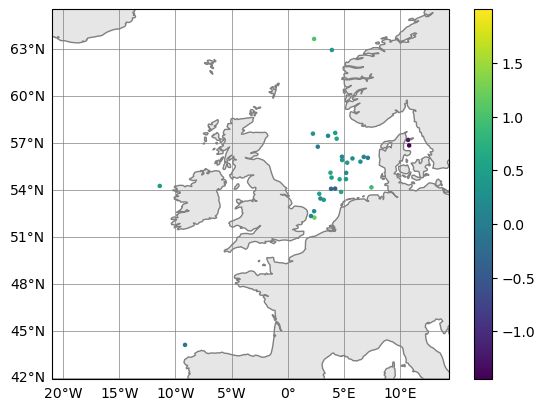

(<Figure size 640x480 with 2 Axes>, <GeoAxes: >)

In [47]:
surface_errors.plot_map(var_str="diff_temperature")